# Casing Integrity Example

- background resistivity average is 1.6 Ωm
- For each well we measure the radial electric fields as far out as the well is deep. We also measured magnetic fields (tangential) at a few points.
- Return Electrode: 1000m from the wellhead, perpendicular to the array of receivers (wire ran close to a straight line).
- freqs DC (1e-6), 0.1, and 1Hz
- Surface casing : outer diameter 10 3/4 in, thickness = 0.011m - set depth 1242 ft
- Production casing : outer diameter 7 in, production = 0.008m - set depth 6079 ft 
- KB 13.5ft above

In [1]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import sympy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot

from SimPEG.EM import FDEM
from SimPEG import Utils, Maps

import casingSimulations

from pymatsolver import Pardiso

%matplotlib inline

In [2]:
simDir = '1km_well_A'

## Set up model parameters

In [3]:
# Casing diameters
surface_casing_diameter = 10.75*inch
production_casing_diameter = 7*inch

# casing depths (below surface)
kb = 13.5
surface_casing_depth = (1242-kb)*foot
production_casing_depth = (6079-kb)*foot

print(surface_casing_depth, production_casing_depth)
print(surface_casing_diameter, production_casing_diameter)

(374.44679999999994, 1848.7643999999998)
(0.27305, 0.17779999999999999)


### Simplified model

In [4]:
# Casing parameters
casing_d = 20e-2 # first pass, lets use a 20cm casing diameter
casing_t = 1e-2 # 1cm casing thickness
casing_l = 1000 # here we use a 1km well and will explore the impacts of meshing choices

freqs = np.r_[1e-4, 1e-3, 1e-2, 0.1, 1.]  # 1e-6

sigma_back = 1./1.6
sigma_inside = 1.

src_a = np.r_[0., np.pi, 0.]
src_b = np.r_[1e3, np.pi, 0.]

In [5]:
# set up the casing properties
cp = casingSimulations.CasingParameters(
    sigma_back = sigma_back,
    sigma_layer = sigma_back,
    sigma_inside = sigma_inside,
    casing_d = casing_d,
    casing_l = casing_l,
    casing_t = casing_t, 
    freqs = freqs, 
    src_a = src_a,
    src_b = src_b
)

In [6]:
cp.save(directory=simDir)

In [7]:
cp.serialize()

{u'__class__': 'CasingParameters',
 'casing_d': 0.2,
 'casing_l': 1000.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'freqs': [0.0001, 0.001, 0.01, 0.1, 1.0],
 'layer_z': [-1000.0, -900.0],
 'mur_casing': 100.0,
 'sigma_air': 1e-08,
 'sigma_back': 0.625,
 'sigma_casing': 5500000.0,
 'sigma_inside': 1.0,
 'sigma_layer': 0.625,
 'src_a': [0.0, 3.141592653589793, 0.0],
 'src_b': [1000.0, 3.141592653589793, 0.0],
 'version': u'0.0.1'}

In [8]:
cp.skin_depth()

array([ 63661.97723676,  20131.68484179,   6366.19772368,   2013.16848418,
          636.61977237])

## Set up mesh

In [9]:
npadx, npadz = 18, 25
dx2 = casing_l  # go out as far as the casing is deep 
csx2 = 25.
csz = 2.5
pfx2 = 1.4
pfz = 1.4

ncy = 1
nstretchy = 5
stretchfact = 1.5
hy = utils.meshTensor([(1, nstretchy, -stretchfact), (1, ncy), (1, nstretchy, stretchfact)])
hy = hy * 2*np.pi/hy.sum()

cylMeshGen = casingSimulations.CasingMeshGenerator(
    cp=cp, 
    npadx=npadx, 
    npadz=npadz, 
    domain_x2=dx2, 
    hy=hy, 
    csx2=csx2, 
    csz=csz,
    pfx2=pfx2, 
    pfz=pfz
)

/anaconda/lib/python2.7/site-packages/matplotlib/projections/polar.py:65: RuntimeWarning: invalid value encountered in less
  mask = r < 0


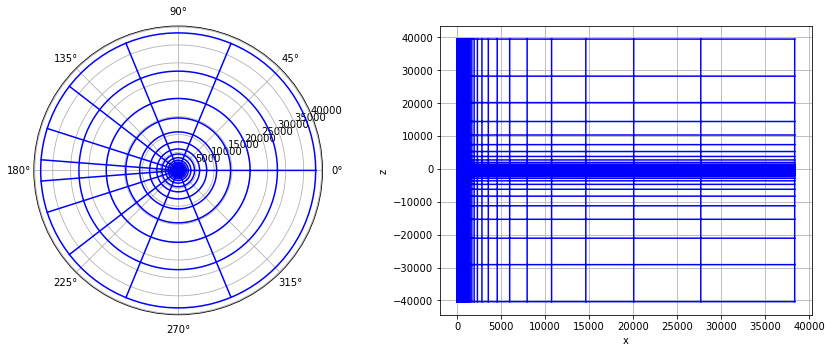

In [10]:
cylMeshGen.mesh.plotGrid()

In [11]:
print( 
    'nC: {}, max_x: {}, max_z: {}'.format(
        cylMeshGen.mesh.nC, cylMeshGen.mesh.vectorNx.max(), cylMeshGen.mesh.vectorNz.max()
    )
)

nC: 693220, max_x: 38364.3997434, max_z: 39377.6963301


In [12]:
cylMeshGen.mesh.vectorCCy

array([ 0.588141  ,  1.56837599,  2.22186599,  2.65752599,  2.94796599,
        3.14159265,  3.33521932,  3.62565932,  4.06131932,  4.71480931,
        5.69504431])

In [13]:
cylMeshGen.save(directory=simDir)

In [14]:
cylmesh = cylMeshGen.mesh

In [15]:
src = casingSimulations.sources.TopCasingSrc(cp, cylMeshGen.mesh)

(0.0, 1900)

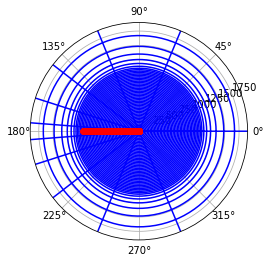

In [16]:
ax = plt.subplot(111, projection='polar')
cylmesh.plotGrid(ax=ax, slice='z')
ax.plot(cylmesh.gridFx[src.surface_wire,1], cylmesh.gridFx[src.surface_wire,0], 'ro')
ax.set_rlim([0., 1900])

(-10.0, 30.0)

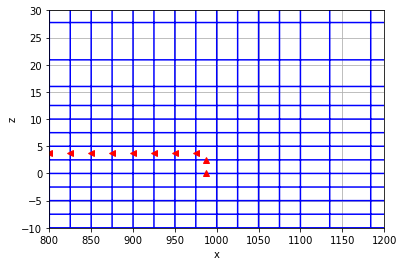

In [17]:
fig, ax = plt.subplots(1, 1)
cylmesh.plotGrid(ax=ax, slice='theta')
src.plot(ax=ax)

ax.set_xlim([800., 1200.])
ax.set_ylim([-10., 30.])

In [18]:
physprops = casingSimulations.PhysicalProperties(cylmesh, cp)

In [19]:
mesh2D = discretize.CylMesh([cylmesh.hx, 1., cylmesh.hz], x0 = cylmesh.x0)

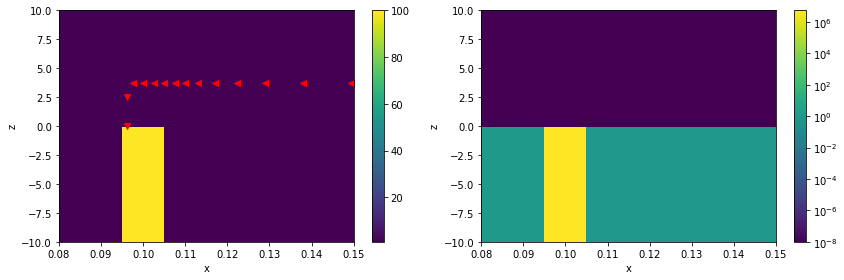

In [20]:
xlim = [0.08, 0.15]
ylim = [-10., 10.]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

murplt = physprops.mur.reshape(cylmesh.vnC, order='F')

plt.colorbar(mesh2D.plotImage(utils.mkvc(murplt[:,0,:]), ax=ax[0], mirror=True)[0], ax=ax[0])
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
src.plot(ax=ax[0])

sigmaplt = physprops.sigma.reshape(cylmesh.vnC, order='F')

plt.colorbar(
    mesh2D.plotImage(
        utils.mkvc(sigmaplt[:,0,:]), ax=ax[1], mirror=True, pcolorOpts = {'norm':LogNorm()}
    )[0], ax=ax[1],
    
)
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)

plt.tight_layout()

In [21]:
casingSimulations.utils.writeSimulationPy(
    directory=simDir, 
    srcType='TopCasingSrc',
)

wrote 1km_well_A/simulation.py


## Set up and run 2D simulations

In [22]:
meshGen2D = casingSimulations.CasingMeshGenerator(
    cp=cp, 
    npadx=npadx, 
    npadz=npadz, 
    domain_x2=dx2, 
    csx2=csx2, 
    csz=csz,
    pfx2=pfx2, 
    pfz=pfz
)

In [23]:
mesh2D = meshGen2D.mesh

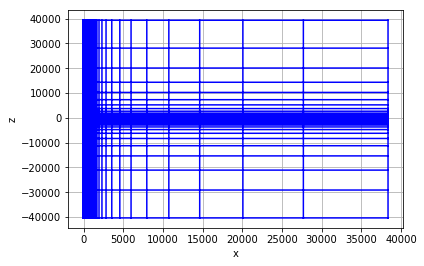

In [24]:
mesh2D.plotGrid()

In [25]:
sim2d = casingSimulations.run.SimulationFDEM(
    cp=cp, meshGenerator=meshGen2D, directory=simDir, 
    simulation_filename='simulation2D.json', fields_filename='fields2D.npy',
    srcType='TopCasingSrc'
)

In [26]:
%%time
fields2D = sim2d.run()

Validating parameters...
      max x: 38364.3997434, min z: -40377.6963301, max z: 39377.6963301
Starting Simulation
Elapsed time : 3.60565304756
CPU times: user 2.82 s, sys: 456 ms, total: 3.28 s
Wall time: 3.62 s


# Load up 3D results

In [27]:
# cylMesh=casingSimulations.load_properties('/'.join([simDir, 'MeshParameters.json']))
# cp = casingSimulations.load_properties('/'.join([simDir, 'CasingParameters.json']))
hfield = np.load('/'.join([simDir, 'fields.npy']))
# simulation = casingSimulations.load_properties(
#     '/'.join([simDir, 'simulationParameters.json']), 
#     targetClass=casingSimulations.run.SimulationFDEM
# )

In [28]:
sim3D = casingSimulations.run.SimulationFDEM(cp=cp, meshGenerator=cylMeshGen, srcType='TopCasingSrc')
sim3D.prob.model = sim3D.physprops.model

In [29]:
%%time
fields3D = sim3D.prob.fieldsPair(cylMeshGen.mesh, sim3D.survey)

CPU times: user 3min 18s, sys: 5.91 s, total: 3min 24s
Wall time: 3min 31s


In [30]:
fields3D[:,'hSolution'] = hfield
srcList = sim3D.survey.srcList

In [31]:
cylmesh = cylMeshGen.mesh
src = sim3D.src

In [32]:
cp.skin_depth()

array([ 63661.97723676,  20131.68484179,   6366.19772368,   2013.16848418,
          636.61977237])

## Set up and run 3D DC

In [33]:
from SimPEG.EM.Static import DC

In [34]:
a_electrode = cylMeshGen.mesh.gridFz[sim3D.src.tophole_electrode, :][0, :] - np.r_[0., 0., cylMeshGen.csz/2.] 
b_electrode = cylMeshGen.mesh.gridFz[sim3D.src.surface_electrode, :][0, :] - np.r_[0., 0., cylMeshGen.csz/2.] 

srcDC = DC.Src.Dipole([], src_a, src_b)
probDC = DC.Problem3D_CC(cylMeshGen.mesh, sigmaMap=sim3D.physprops.wires.sigma, bc_type='Dirichlet', Solver=Pardiso)
surveyDC = DC.Survey([srcDC])

probDC.pair(surveyDC)

Homogeneous Dirichlet is the natural BC for this CC discretization.


In [35]:
# %%time
# fieldsDC = probDC.fields(sim3D.physprops.model)
# np.save('/'.join([simDir, 'fieldsDC.npy']), fieldsDC[:, 'phiSolution'])
phi = np.load('/'.join([simDir, 'fieldsDC.npy']))
probDC.sigma = sim3D.physprops.sigma
fieldsDC = probDC.fieldsPair(cylmesh, surveyDC)
fieldsDC[:,'phiSolution'] = phi

# Plot the Results

In [36]:
import ipywidgets

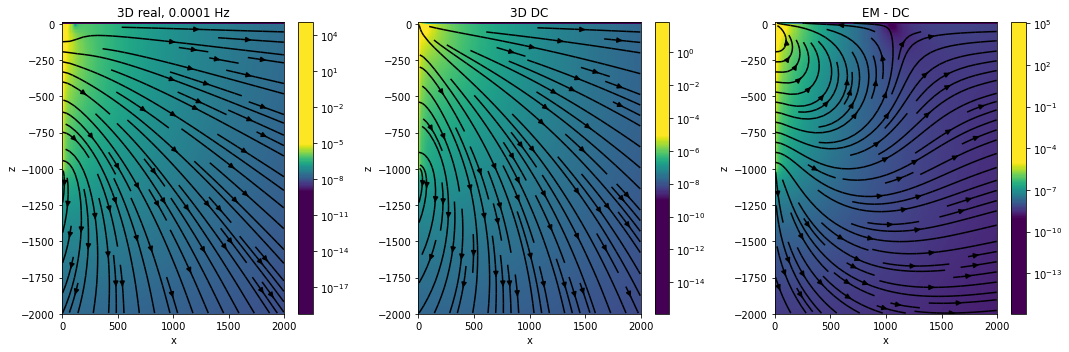

<function __main__.plotCurrents>

In [37]:
mesh2D = discretize.CylMesh([cylMeshGen.mesh.hx, 1., cylMeshGen.mesh.hz], x0=cylMeshGen.mesh.x0)

srcind = 2
theta_ind = 5

plotopts = {
    'range_x':np.r_[0., 2000.],
    'range_y':np.r_[-2000., 10.], 
    'sample_grid':np.r_[10., 10.],
    'logScale':True, 
    'clim':[1e-9, 1e-5]
}


def plotCurrents(srcind=0, theta_ind=5):
    jcyl = fields3D[srcList[srcind],'j']
    # j2D = fields2D[sim2d.survey.srcList[srcind], 'j']
    jDC = fieldsDC[:,'j']

    jplt = casingSimulations.face3DthetaSlice(cylMeshGen.mesh, jcyl, theta_ind=theta_ind)
    jDCplt = casingSimulations.face3DthetaSlice(cylMeshGen.mesh, jDC, theta_ind=theta_ind)

    fig, ax = plt.subplots(1,3, figsize=(15, 5))
    ax = utils.mkvc(ax)

    reim = 'real'
    casingSimulations.plotFace2D(
        mesh2D,
        jplt, real_or_imag=reim, ax=ax[0],
        **plotopts
    )
    ax[0].set_title('3D {}, {} Hz'.format(reim, srcList[srcind].freq))

    casingSimulations.plotFace2D(
        mesh2D,
        jDCplt, real_or_imag='real', ax=ax[1], 
        **plotopts
    )
    ax[1].set_title('3D {}'.format('DC'))

    casingSimulations.plotFace2D(
        mesh2D,
        jplt-jDCplt, real_or_imag='real', ax=ax[2], 
        **plotopts
    )
    ax[2].set_title('EM - DC')

    plt.tight_layout()
    plt.show()

ipywidgets.interact(plotCurrents, srcind=ipywidgets.IntSlider(min=0, max=len(srcList)-1, step=1), theta_ind=ipywidgets.IntSlider(min=0, max=cylMeshGen.mesh.nCy-1, step=1))

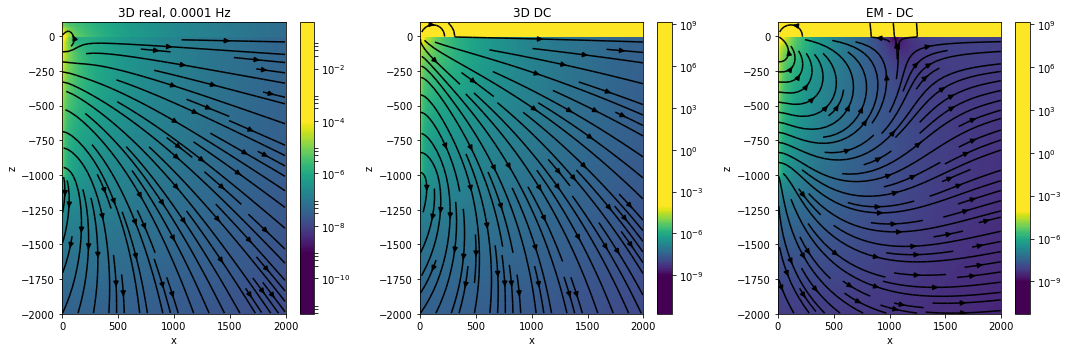

<function __main__.plotEfield>

In [38]:
mesh2D = discretize.CylMesh([cylMeshGen.mesh.hx, 1., cylMeshGen.mesh.hz], x0=cylMeshGen.mesh.x0)

srcind = 2
theta_ind = 5

plotopts = {
    'range_x':np.r_[0., 2000.],
    'range_y':np.r_[-2000., 100.], 
    'sample_grid':np.r_[10., 10.],
    'logScale':True, 
    'clim':[1e-9, 1e-4]
}


def plotEfield(srcind=0, theta_ind=5):
    ecyl = fields3D[srcList[srcind],'e']
    # e2D = fields2D[sim2d.survey.srcList[srcind], 'e']
    eDC = fieldsDC[:,'e']

    eplt = casingSimulations.face3DthetaSlice(cylMeshGen.mesh, ecyl, theta_ind=theta_ind)
    eDCplt = casingSimulations.face3DthetaSlice(cylMeshGen.mesh, eDC, theta_ind=theta_ind)

    fig, ax = plt.subplots(1,3, figsize=(15, 5))
    ax = utils.mkvc(ax)

    reim = 'real'
    casingSimulations.plotFace2D(
        mesh2D,
        eplt, real_or_imag=reim, ax=ax[0],
        **plotopts
    )
    ax[0].set_title('3D {}, {} Hz'.format(reim, srcList[srcind].freq))

    casingSimulations.plotFace2D(
        mesh2D,
        eDCplt, real_or_imag='real', ax=ax[1], 
        **plotopts
    )
    ax[1].set_title('3D {}'.format('DC'))

    casingSimulations.plotFace2D(
        mesh2D,
        eplt-eDCplt, real_or_imag='real', ax=ax[2], 
        **plotopts
    )
    ax[2].set_title('EM - DC')

    plt.tight_layout()
    plt.show()

ipywidgets.interact(plotEfield, srcind=ipywidgets.IntSlider(min=0, max=len(srcList)-1, step=1), theta_ind=ipywidgets.IntSlider(min=0, max=cylMeshGen.mesh.nCy-1, step=1))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1119d9510>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1188d9ed0>], dtype=object)

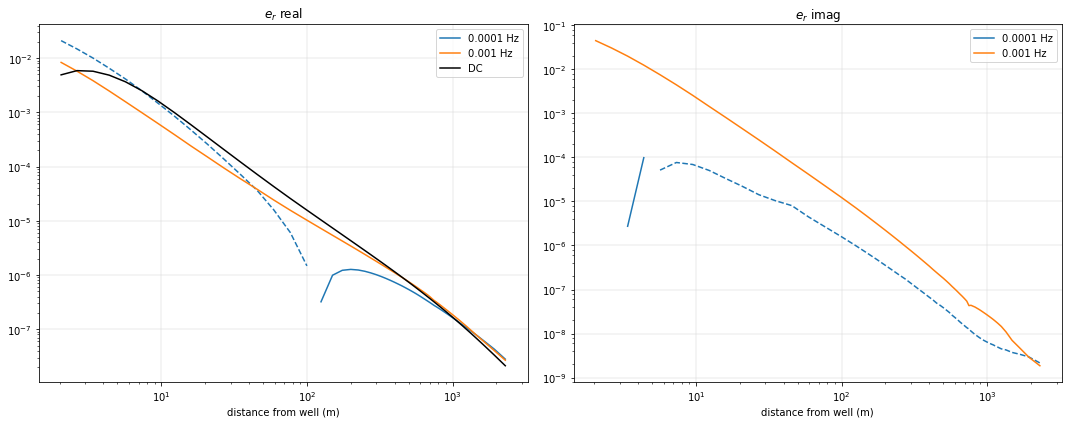

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax = utils.mkvc(ax)
    
casingSimulations.view.plotLinesFx(
    cylmesh,
    sim3D.survey.srcList[:2],
    fields3D=fields3D,
    fieldsDC=fieldsDC,
    fieldType='e',
    pltType='loglog',
    ax=ax,
    theta_ind=0,
    xlim=[0., 2500.],
    zloc=0.
)

In [40]:
import casingSimulations